# Interpretabilidade: "Visualizando" o que as redes neurais aprendem  

Costuma-se dizer que os modelos de aprendizado profundo são "caixas pretas", representações de aprendizado difíceis de extrair e apresentar de forma legível por humanos. Embora isso seja parcialmente verdadeiro para certos tipos de modelos de aprendizado profundo, as representações aprendidas pelas CNNs são passíveis de visualização, em grande parte porque são representações de conceitos visuais. Também é possível visualizar as interações de palavras e conceitos em uma rede Transformer, e ter um certo nível de interpretabilidade de como a rede está aprendendo. Desde 2013, uma ampla gama de técnicas foi desenvolvida para visualizar e interpretar essas representações.

#  **Visualização de Mapas de Calor de Ativação de Classe**


Apresentaremos mais uma técnica de visualização. Essa categoria geral de técnicas é chamada de visualização "Class Activation Map" (CAM) e consiste na produção de mapas de calor acerca da "ativação" sobre imagens de entrada. Um mapa de calor de "ativação de classe" é uma matriz 2D de pontuações associadas a uma classe de saída específica, calculada para cada região na imagem de entrada, indicando a importância de cada região em relação à classe considerada. Por exemplo, dada uma imagem, a visualização do Mapa de Ativação de Classe nos permite gerar um mapa de calor para a classe "gato", indicando como as diferentes partes da imagem são parecidas com gatos e, da mesma forma, para a classe "cachorro", indicando como as diferentes partes da imagem são parecidas com cachorros.

In [1]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
K.set_image_data_format('channels_last')

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 11s 0us/step


In [2]:
!wget https://worldbirds.com/wp-content/uploads/2020/05/elephant-symbolism6.jpg -O elephant.jpg

--2024-05-17 18:29:55--  https://worldbirds.com/wp-content/uploads/2020/05/elephant-symbolism6.jpg
Resolving worldbirds.com (worldbirds.com)... 172.66.41.28, 172.66.42.228, 2606:4700:3108::ac42:2ae4, ...
Connecting to worldbirds.com (worldbirds.com)|172.66.41.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210172 (205K) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 205.25K  --.-KB/s    in 0.03s   

2024-05-17 18:29:55 (6.31 MB/s) - ‘elephant.jpg’ saved [210172/210172]



In [3]:
from tensorflow import keras
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf

# Display
from IPython.display import Image, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# The local path to our target image
img_path = 'elephant.jpg'

# `img` is a PIL image of size 224x224
img = load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

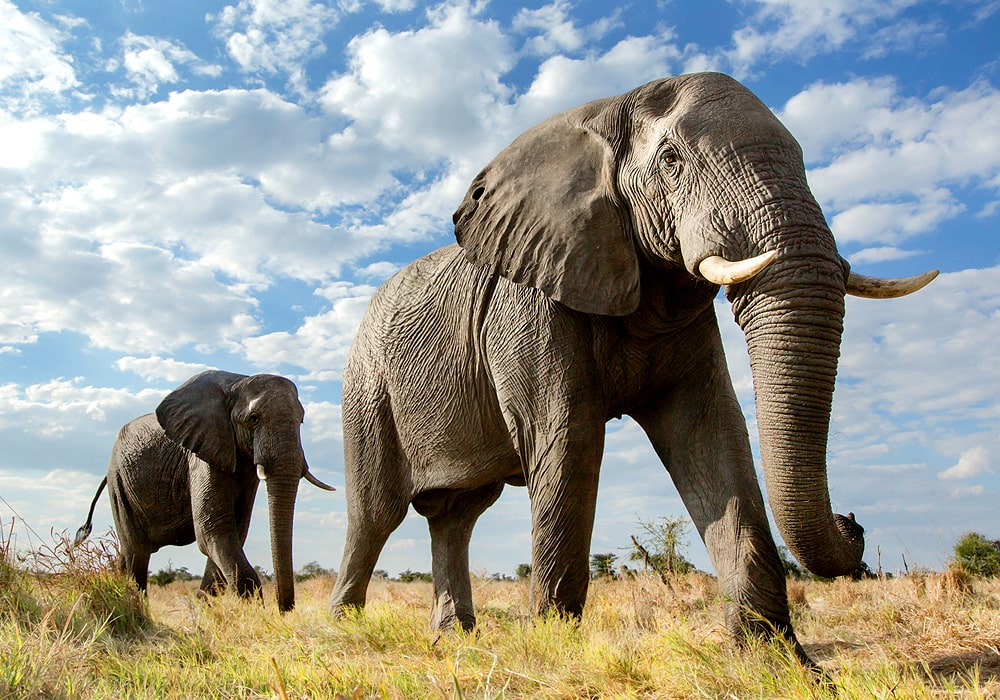

In [4]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

display(Image(img_path))

## Algoritmo e Funções Auxiliares

A implementação que utilizaremos a seguir é a descrita no paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391). De modo geral, a ideia é relativamente simples: consiste em pegar o mapa de características de saída de uma camada de convolução dada uma imagem de entrada e pesar cada canal nesse mapa de características pelo gradiente da classe em relação ao canal. Intuitivamente, uma maneira de entender esse truque é que estamos ponderando um mapa espacial de "quão intensamente a imagem de entrada ativa diferentes canais" por "quão importante cada canal é em relação à classe", resultando em um mapa espacial de "quão intensamente a imagem de entrada ativa a classe".

## Aplicação

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [6]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

last_conv_layer_name = "block14_sepconv2_act"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 9.517476)]


In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

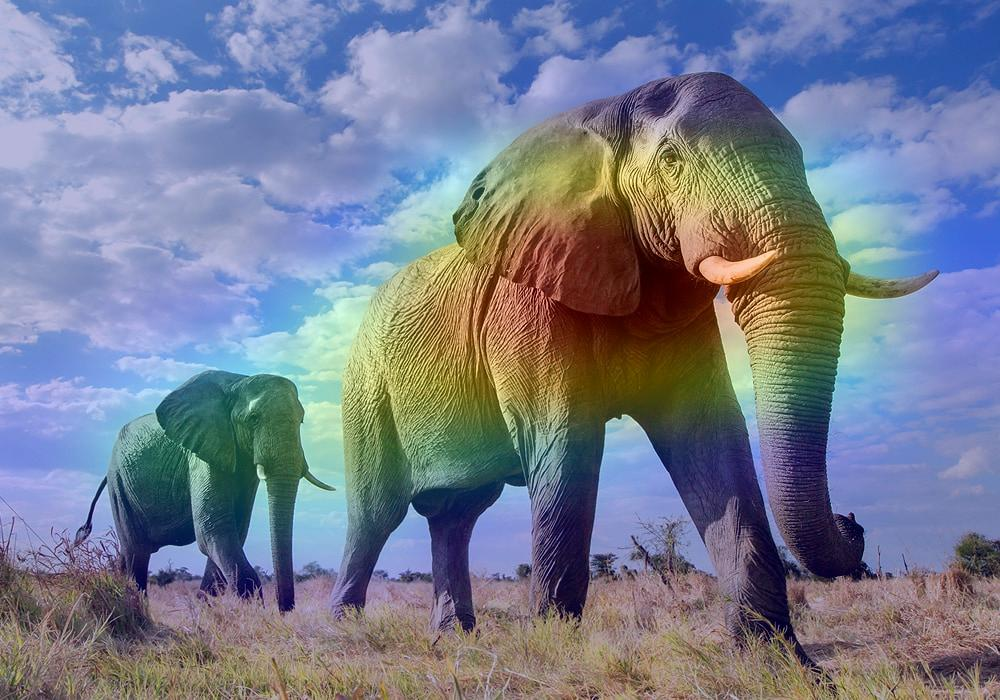

In [8]:
save_and_display_gradcam(img_path, heatmap)

#  **Visualização de Camadas de Atenção em Modelos Transformers**

Algumas destas ferramentas são utilizadas principalmente para interpretabilidade em imagens e outras em textos, como o **BertViz** e a **Captum**. A BertViz é um exemplo de ferramenta para visualização em relação aos dados textuais. BertViz é uma ferramenta interativa para visualização de camadas de atenção em modelos Transformer, como exemplo, BERT, GPTs ou modelos T5.

Vamos iniciar instalando a biblioteca bertviz. Pode ser facilmente instalada através do do pacote bertviz, través do pip.

In [ ]:
!pip install bertviz

É necessário selecionar um modelo que será utilizado para realizar as relações entre as palavras de cada texto que daremos como entrada. Neste prática estamos definindo como modelo padrão o BERT e utilizando a versão base. Porém a biblioteca Berviz é compatível com qualquer modelos transformer, como BERT, BERTimbau, Roberta, GPT ou T5.

A partir do modelo selecionado, basta realizar inferência através das frases definidas de entrada. Como saída temos as probabilidades para cada uma das palavras em relação as camadas transformers do modelo. Por fim, realizamos a transformação dos ids resultantes para uma forma em linguagem natural.

In [10]:
# Carrega o modelo e o tokenizador

from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

# Utiliza o modelo bert-base-uncased
# BERT Base

model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

# Definimos duas frases que serão dadas de entrada para o modelo transformer.
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"

# Realizamos a tokenização das frases e separamos os ids e tipos de token para cada palavra da frase.
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']

# Inferência no modelo BERT para as entradas definidas
attention = model(input_ids, token_type_ids=token_type_ids)[-1]

# Definições de início de frases e retorno de ids para palavras
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Visualização dos Pesos por Cabeças Transformers (Head View)
Visualiza a atenção em uma ou mais cabeças de uma única camada do Transformer. Cada linha mostra a atenção de um token (à esquerda) para outro (à direita). A espessura da linha reflete o valor da atenção (varia de 0 a 1), enquanto a cor da linha identifica a cabeça da atenção. Quando várias cabeças são selecionadas (indicadas pelos blocos coloridos na parte superior), as visualizações correspondentes são sobrepostas umas às outras.

In [11]:
head_view(attention, tokens, sentence_b_start)

Output hidden; open in https://colab.research.google.com to view.

# Visualização geral do Modelo (Model View)
A visualização geral do modelo fornece uma visão panorâmica da atenção em todo o modelo. Cada célula mostra os pesos de atenção para uma cabeça específica, indexada por camada (linha) e cabeça (coluna). As linhas em cada célula representam a atenção de um token (à esquerda) para outro (à direita), com peso de linha proporcional ao valor da atenção (varia de 0 a 1).

Esta visualização pode ser utilizada através do método model view, que tem como entrada os pesos de atenção anteriormente calculados, as palavras das frases tokenizadas (tokens) e o início da segunda sentença.

In [12]:
model_view(attention, tokens, sentence_b_start)

Output hidden; open in https://colab.research.google.com to view.

Podemos observar alguns padrões nas camadas de atenção em relação as camadas do modelo:


*   Atenção para a próxima palavra (Camada 0, Cabeça 10)
*   Atenção para a palavra anterior (Camada 3, Cabeça 5)
*   Atenção em palavras identicas ou relacionadas (Camada 11, Cabeça 8)
*   Atenção em palavras identicas ou relacionadas em outras sentenças (Camada 11, Cabeça 8)
*   Atenção a outras palavras preditivas desta palavra
*   Atenção aos tokens de delimitação (Camada 11, Cabeça 0)
*   Atenção no formato Bag of Words (Camada 3, Cabeça 7)




# Visualização intermediária por Operação (Neuron View)
Esta visualização demonstra as representações intermediárias (por exemplo, consulta (query) e vetores-chave (keys) que são usadas para calcular a atenção. Na visualização recolhida (estado inicial), as linhas mostram a atenção de cada token (esquerda) para cada outra ficha (à direita). Na exibição expandida, a ferramenta rastreia a cadeia de cálculos que produzem esses pesos de atenção.

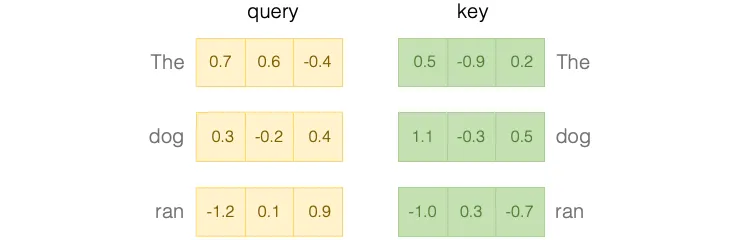

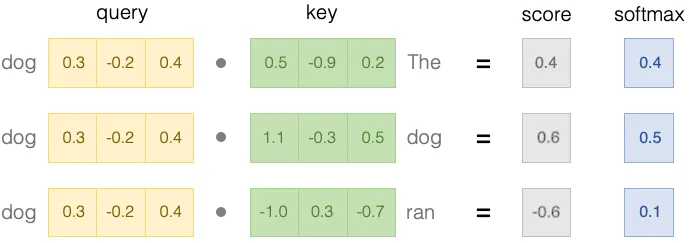

Como entrada para o método show, responsável por criar a visualização intermediária, é necessário o modelo, o tipo do modelo utilizado, as sentenças que serão utilizadas e a camada e cabeça que inicialmente estará demonstrada no diagrama.

In [13]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)
show(model, model_type, tokenizer, sentence_a, sentence_b, layer=4, head=3)

Output hidden; open in https://colab.research.google.com to view.

# Referências

[BertViz github repository](https://github.com/jessevig/bertviz) que contém toda documentação e casos adicionais, em outros modelos.